# 5 - Sizing
We will optimize truss structures in this exercise. There is a prepared Python class for trusses called `Truss` and you can import it via `from utils import Truss`. The next cell shows an example of how to use the truss class.

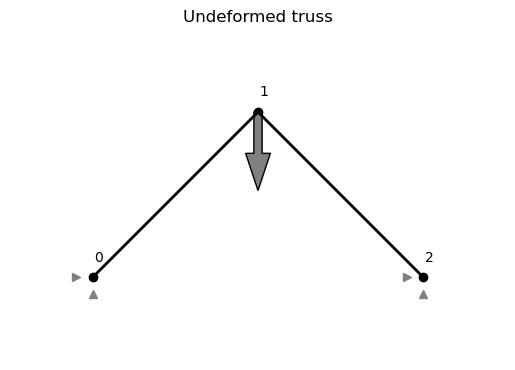

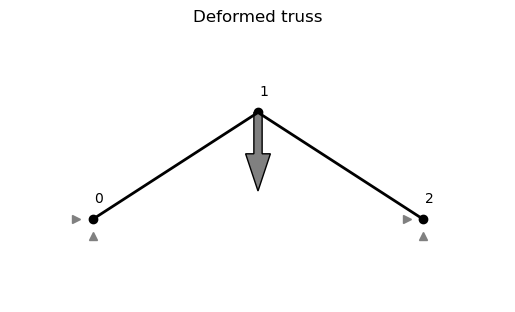

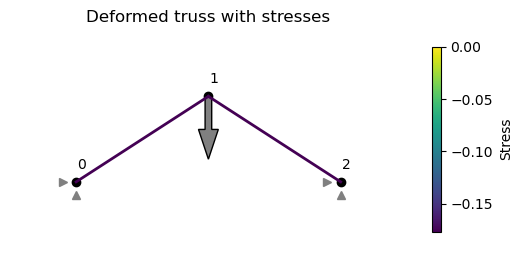

The lengths of elemensts are: tensor([1.4142, 1.4142])
The strain energies in each element are: tensor([0.0221, 0.0221])


In [13]:
from math import sqrt, log

import torch
import matplotlib.pyplot as plt

from simple_truss import Truss


# Define three nodes
nodes = torch.tensor([[0.0, 0.0], [1.0, 1.0], [2.0, 0.0]])
# Define two elements connecting nodes
elements = torch.tensor([[0, 1], [1, 2]])
# Define a single force downwards in x_2 direction
forces = torch.zeros_like(nodes)
forces[1, 1] = -0.25
# Constrain all DOFs except for the central node
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, :] = True
constraints[2, :] = True
# Design choice of cross sectional areas
x = torch.ones((len(elements)))

# Define truss
sample_truss = Truss(nodes, elements, forces, constraints, E=1.0)

# Plot undeformend truss
sample_truss.plot()
plt.title("Undeformed truss")
plt.show()

# Compute the solution of the truss problem
u, f, sigma = sample_truss.solve(x)

# Plot deformend truss
sample_truss.plot(u=u)
plt.title("Deformed truss")
plt.show()

# Plot deformend truss with stresses
sample_truss.plot(u=u, sigma=sigma)
plt.title("Deformed truss with stresses")
plt.show()

# Get truss properties
l0 = sample_truss.element_lengths()
print(f"The lengths of elemensts are: {l0}")
w = sample_truss.element_strain_energies(u)
print(f"The strain energies in each element are: {w}")

## Task 1 - Solving a simple truss structure
Consider the three bar truss example from a previous exercise and the lecture example shown below. The truss is subjected to a force $P=-0.2$ indicated by the gray arrow and supports indicated by gray triangles. It has three nodes 
$$
    \mathcal{N} = \{\mathbf{n}^0=(1,0)^\top, \mathbf{n}^1=(0,0)^\top,\mathbf{n}^2=(0,1)^\top \}
$$
and three elements 
$$
    \mathcal{E} = \{(\mathbf{n}^0, \mathbf{n}^1), (\mathbf{n}^0, \mathbf{n}^2), (\mathbf{n}^1, \mathbf{n}^2)\}.
$$



Create a truss model named `three_bar_truss` representing this truss assuming $E=10.0$ and $A=1.0$ for each element. Solve the truss problem and plot the truss in its deformed configuration with colors representing stresses in bars.

![](figures/three_bar_truss.png)

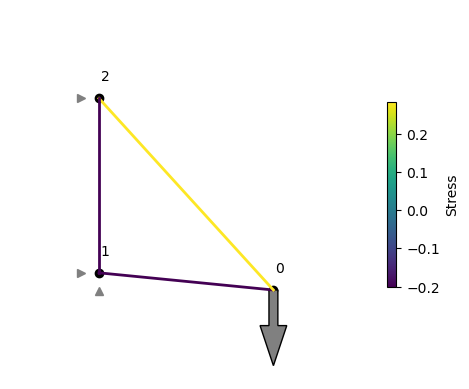

In [14]:
# Nodes
nodes = torch.tensor([[1.0, 0.0], [0.0, 0.0], [0.0, 1.0]])
# Elements
elements = torch.tensor([[0, 1], [0, 2], [1, 2]])
# Forces
forces = torch.zeros_like(nodes)
forces[0, 1] = -0.2
# Constraints
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[1, 0] = True
constraints[1, 1] = True
constraints[2, 0] = True
# Cross section design
x = torch.ones((len(elements)))

# Create truss
three_bar_truss = Truss(nodes, elements, forces, constraints, E=10.0)
# Solve truss
u, f, sigma = three_bar_truss.solve(x)
# Plot truss
three_bar_truss.plot(u=u, sigma=sigma)

## Task 2 - Bisection algorithm 
To solve the dual problem, we will need to find the roots $\mu^*>0$ of the gradient 
$$
\frac{\partial \underline{\mathcal{L}}}{\partial \mu}(\mu) = \mathbf{l} \cdot \mathbf{x}^* (\mu) - V_0 = 0
$$
later. To prepare the search for these roots, you should implement a bisection algorithm. This algorithm performs well in this case of a highly non-linear convex optimization task, but in principle, you could also use any other gradient based algortihtm from previous exercises.

a) Write a function `bisection(f, a, b, max_iter=50, tol=1e-10)` that takes a function `f`, a bracket $[a,b]$ with $a<b$, an iteration limit `max_iter` and a tolerance for the solution `tol`. It should implement the following algorithm:
 - While $b-a > tol$: 
   - $c = \frac{a+b}{2}$
   - if $f(a)$ and $f(b)$ have the same sign, replace a with c 
   - else replace b with c 

Break the loop, if the iteration count `max_iter` is exceeeded to prevent infinite loops.

In [15]:
def bisection(f, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

b) Test the function with the function $f(x)=x^3-\log(x)-5$.

In [16]:
def f(x):
    return x**3 - log(x) - 5.0

root = bisection(f, 0.1, 10.0)
print(root)

1.7729093296358767


## Task 3 - Optimization algorithm
Implement a truss optimization algorithm according to Example 27 in the lecture. To do so, define a function `optimize(truss, x_0, x_min, x_max, V_0)`

In [17]:
def optimize(truss, a_0, a_min, a_max, V_0):
    L = []
    l = truss.element_lengths()
    iter = 10
    s = 0.7

    a = [a_0]

    # Iterate solutions
    for k in range(iter):
        # Solve the truss problem at point x_k
        u_k, f_k, sigma_k = truss.solve(a[k])

        # Get strain energy of all truss elements for the given displacement
        w_k = truss.element_strain_energies(u_k)

        # Compute lower asymptote
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            for j in range(len(L_k)):
                if (a[k][j] - a[k - 1][j]) * (a[k - 1][j] - a[k - 2][j]) < 0.0:
                    L_k[j] = a[k][j] - s * (a[k - 1][j] - L[k - 1][j])
                else:
                    L_k[j] = a[k][j] - 1 / sqrt(s) * (a[k - 1][j] - L[k - 1][j])
            L.append(L_k)
        else:
            L.append(x[k] - s * (a_max - a_min))

        # Compute lower move limit in this step
        a_min_k = torch.maximum(a_min, 0.9 * L[k] + 0.1 * a[k])

        # Analytical solution
        def a_star(mu):
            EPS = 1e-15  # Trick to prevent division by zero
            a_hat = L[k] + torch.sqrt(
                (2 * w_k * (L[k] - a[k]) ** 2 + EPS) / (mu * l + EPS)
            )
            return torch.maximum(torch.minimum(a_hat, a_max), a_min_k)

        # Analytical gradient
        def grad(mu):
            return torch.dot(a_star(mu), l) - V_0

        # Solve dual problem
        mu_star = bisection(grad, 0.0, 100.0)

        # Compute current optimal point with dual solution
        a.append(a_star(mu_star))

    return a

Test the optimization algortihm with the following code.

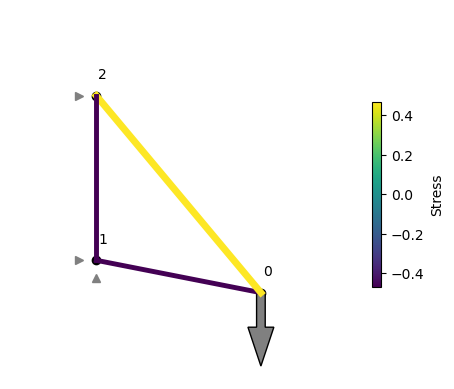

In [18]:
a_0 = torch.tensor([0.5, 0.2, 0.3])
a_min = 0.1 * torch.ones_like(a_0)
a_max = 1.0 * torch.ones_like(a_0)
l = three_bar_truss.element_lengths()
V0 = 0.5 * torch.dot(a_max, l)

a_opt = optimize(three_bar_truss, a_0, a_min, a_max, V0)
u, f, sigma = three_bar_truss.solve(a_opt[-1])
three_bar_truss.plot(u=u, sigma=sigma, a=a_opt[-1])

## Task 4 - Questions and effects

a) Is the optimized truss a fully stressed design?

## Task 5 - Create your own truss and optimize it